In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import utils

In [2]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
analysis_folder = os.path.join(data_dir, 'hazard_analysis')
os.makedirs(analysis_folder, exist_ok=True)

In [3]:
# Use lighter blue and orange for better visibility
lighter_blue = '#6baed6'   # light blue
lighter_orange = '#fdcc8a' # light orange

In [4]:
sessions_training = utils.load_data(os.path.join(data_folder, f'sessions_training_{exp}.csv'))
trials_training = utils.load_data(os.path.join(data_folder, 'trials_training_filtered2.csv'))

sessions_training = sessions_training.sort_values(by='num_trials', ascending=False)

In [5]:
sessions_053 = sessions_training.loc[sessions_training['mouse'] == 'RZ053']

In [6]:
def stitch_all_events(data_folder, sessions_log):
    events_list = []
    for _, session_info in sessions_log.iterrows():
        events = utils.load_data(utils.generate_events_processed_path(data_folder, session_info))
        trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        events = events.merge(
            trials[['session_trial_num', 'good_trial']],
            on='session_trial_num',
            how='left'
        )
        events[['dir', 'mouse', 'date', 'time', 'avg_tw', 'session']] = session_info[['dir', 'mouse', 'date', 'time', 'avg_tw', 'session']].values
        events_list.append(events)
    events_all = pd.concat(events_list, ignore_index=True)
    return events_all


In [7]:
events_stitched = stitch_all_events(data_folder, sessions_053)

In [8]:
licks = events_stitched[(events_stitched['key'] == 'lick') & (events_stitched['value'] == 1) & (events_stitched['state'] != 'in_consumption')]

In [9]:
dir_list = events_stitched.dir.unique()

In [10]:
trials = trials_training.loc[trials_training['dir'].isin(dir_list)]

In [11]:
def binned_rate_normalized(licks_subset, bins, bin_size, bin_centers):
    grouped = licks_subset.groupby('session_trial_num')['trial_time'].apply(
        lambda x: np.histogram(x, bins=bins)[0].astype(float)
    )
    if grouped.empty:
        return np.zeros(len(bin_centers)), np.zeros(len(bin_centers))
    arr = np.stack(grouped.values)
    arr = arr / arr.sum(axis=1, keepdims=True)  # normalize area=1 per trial
    return arr.mean(axis=0) / bin_size, arr.std(axis=0) / np.sqrt(arr.shape[0]) / bin_size

All trials - Peak time: 5.356 s
Good trials - Peak time: 6.356 s
Not good trials - Peak time: 4.956 s

bg_drawn mean: 5.000 s


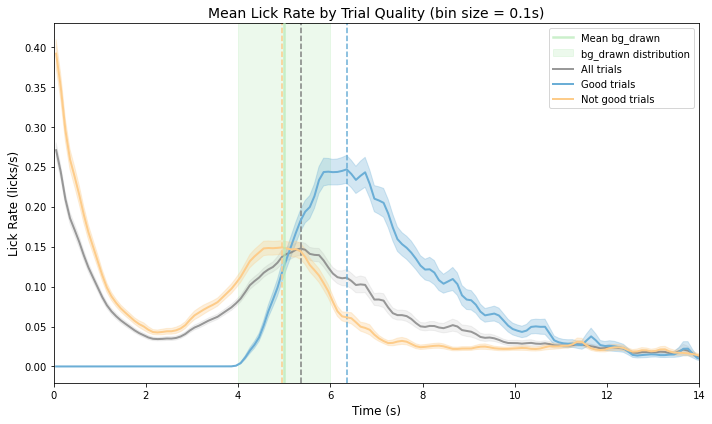

In [12]:
bin_size = 0.1
bins = np.arange(licks['trial_time'].min(), licks['trial_time'].max() + bin_size, bin_size)
bin_centers = (bins[:-1] + bins[1:]) / 2

results = {}
for label, mask, color in [
    ('All trials', slice(None), 'gray'),
    ('Good trials', licks['good_trial'] == True, lighter_blue),
    ('Not good trials', licks['good_trial'] == False, lighter_orange)
]:
    mean, sem = binned_rate_normalized(licks[mask], bins, bin_size, bin_centers)
    mean_smooth = gaussian_filter1d(mean, sigma=1)
    sem_smooth = gaussian_filter1d(sem, sigma=1)
    time_mask = (bin_centers >= 3) & (bin_centers <= 7)
    peak_idx = np.argmax(mean_smooth[time_mask])
    peak_time = bin_centers[time_mask][peak_idx]
    results[label] = dict(mean=mean_smooth, sem=sem_smooth, color=color, peak_time=peak_time)

for label, res in results.items():
    print(f"{label} - Peak time: {res['peak_time']:.3f} s")

# Calculate bg_drawn statistics
bg_mean = trials['bg_drawn'].mean()
bg_low = trials['bg_drawn'].min()
bg_high = trials['bg_drawn'].max()
# bg_std = trials['bg_drawn'].std()
print(f"\nbg_drawn mean: {bg_mean:.3f} s")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bg_drawn shading first (so it's in the background)
ax.axvline(bg_mean, color='#b6eab6', linestyle='-', linewidth=2.5, label='Mean bg_drawn', zorder=10, alpha=0.7)
ax.axvspan(bg_low, bg_high, alpha=0.25, color='#b6eab6', label='bg_drawn distribution', zorder=1)

# Plot lick rates
for label, res in results.items():
    ax.plot(
        bin_centers, res['mean'], linewidth=2, color=res['color'], label=label,
        alpha=0.8 if label=='All trials' else 1
    )
    ax.fill_between(
        bin_centers, res['mean'] - res['sem'], res['mean'] + res['sem'],
        alpha=0.1 if label=='All trials' else 0.3, color=res['color']
    )
    ax.axvline(
        res['peak_time'], color=res['color'],
        linestyle='--',
        linewidth=1.5,
        alpha=1
    )

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Lick Rate (licks/s)', fontsize=12)
ax.set_title(f'Mean Lick Rate by Trial Quality (bin size = {bin_size}s)', fontsize=14)
ax.set_xlim(0, 14)
ax.legend()
plt.tight_layout()
plt.savefig(f'{analysis_folder}/lick_rate_by_trial_quality.png', dpi=300, bbox_inches='tight')

In [13]:
sessions_training

,date,time,mouse,exp,training,rig,avg_tw,ending_code,dir,cohort,version,num_blocks,num_trials,rewards,session_time,group,session
1676,2025-02-11,12-33-23,RZ062,exp2_short,regular,rig4,0.50,reward,2025-02-11_12-33-23_RZ062,cohort_7,post,2.0,1337.0,1110.0,8026.62,s,34
943,2024-09-03,12-30-53,RZ053,exp2_long,regular,rig3,1.43,reward,2024-09-03_12-30-53_RZ053,cohort_6,post,2.0,872.0,1400.0,9931.97,l,50
1028,2024-09-20,12-54-21,RZ053,exp2_long,regular,rig5,3.39,reward,2024-09-20_12-54-21_RZ053,cohort_6,post,3.0,868.0,2075.0,10682.31,l,60
1072,2024-09-27,11-55-06,RZ054,exp2_long,regular,rig5,1.08,reward,2024-09-27_11-55-06_RZ054,cohort_6,post,2.0,862.0,1260.0,13421.71,l,63
934,2024-08-30,12-03-27,RZ053,exp2_long,regular,rig3,1.37,reward,2024-08-30_12-03-27_RZ053,cohort_6,post,3.0,861.0,1595.0,10211.60,l,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,2025-03-05,14-21-15,RZ058,exp2_long,regular,rig4,25.12,miss,2025-03-05_14-21-15_RZ058,cohort_7,post,1.0,30.0,110.0,821.82,l,46
1196,2024-10-29,11-05-26,RZ049,exp2_short,regular,rig1,21.33,miss,2024-10-29_11-05-26_RZ049,cohort_6,post,1.0,21.0,55.0,337.31,s,75
1137,2024-10-15,11-45-11,RZ054,exp2_long,regular,rig1,3.08,manual,2024-10-15_11-45-11_RZ054,cohort_6,post,1.0,21.0,55.0,386.81,l,71
1754,2025-03-04,11-40-10,RZ059,exp2_long,regular,rig4,32.92,miss,2025-03-04_11-40-10_RZ059,cohort_7,post,1.0,19.0,65.0,643.41,l,44


In [14]:
trials_sorted = trials.sort_values(by=['dir', 'session_trial_num'])

In [15]:
trials_sorted.keys()

Index(['block_trial_num', 'block_num', 'start_time', 'end_time', 'bg_drawn',
       'bg_length', 'bg_repeats', 'num_bg_licks', 'miss_trial', 'time_waited',
       'reward', 'num_consumption_lick', 'num_pump', 'first_lick',
       'second_lick', 'third_lick', 'fourth_lick', 'good_trial',
       'previous_trial_bg_repeats', 'previous_trial_time_waited',
       'previous_trial_reward', 'previous_trial_miss_trial',
       'bg_repeats_rolling_mean_5', 'bg_repeats_rolling_mean_10',
       'time_waited_rolling_mean_5', 'time_waited_rolling_mean_10',
       'trial_fraction_in_session', 'trial_fraction_in_block',
       'block_fraction_in_session', 'rewarded_streak', 'unrewarded_streak',
       'reward_rate_since_block_start', 'time_since_last_reward_in_block',
       'cumulative_reward_in_block', 'reward_rate_past_1min_in_block',
       'reward_rate_past_5min_in_block', 'reward_rate_past_10min_in_block',
       'cumulative_reward', 'group', 'dir', 'mouse', 'date', 'time', 'avg_tw',
       'ses

In [16]:
# Prepare per-trial times dataframe
trial_data = trials_sorted.copy()

# Background phase: time to first lick or bg_length if no lick; event indicator
trial_data['t_bg'] = np.where(
    trial_data['first_lick'].notna() & (trial_data['first_lick'] < trial_data['bg_length']),
    trial_data['first_lick'],
    trial_data['bg_length']
)
trial_data['e_bg'] = ((trial_data['first_lick'].notna()) & (trial_data['first_lick'] < trial_data['bg_length'])).astype(int)

# Wait phase: time_waited and event indicator (not miss_trial)
trial_data['t_wait'] = trial_data['time_waited']
trial_data['e_wait'] = (~trial_data['miss_trial']).astype(int)

# Simple empirical hazard function
def empirical_hazard(times, events, bins=60):
    times = np.asarray(times, dtype=float)
    events = np.asarray(events, dtype=int)
    t_max = times.max() if times.size else 0.0
    edges = np.linspace(0.0, t_max if t_max > 0 else 1.0, bins + 1)
    left, right = edges[:-1], edges[1:]
    centers = (left + right) / 2.0
    event_counts = [((times >= L) & (times < R) & (events == 1)).sum() for L, R in zip(left, right)]
    at_risk = [(times >= L).sum() for L in left]
    hazard = np.array(event_counts) / np.maximum(at_risk, 1)
    return centers, hazard

# Compute hazards
cent_bg, haz_bg = empirical_hazard(trial_data["t_bg"], trial_data["e_bg"], bins=50)
cent_w, haz_w = empirical_hazard(trial_data["t_wait"], trial_data["e_wait"], bins=50)

In [17]:
# Compute survival functions from hazard functions
def hazard_to_survival(centers, hazard):
    """Convert hazard function to survival function."""
    # Cumulative hazard: H(t) = sum of hazards up to time t
    cumulative_hazard = np.cumsum(hazard)
    # Survival: S(t) = exp(-H(t))
    survival = np.exp(-cumulative_hazard)
    return centers, survival

# Convert hazards to survival functions
cent_bg_surv, surv_bg = hazard_to_survival(cent_bg, haz_bg)
cent_w_surv, surv_w = hazard_to_survival(cent_w, haz_w)

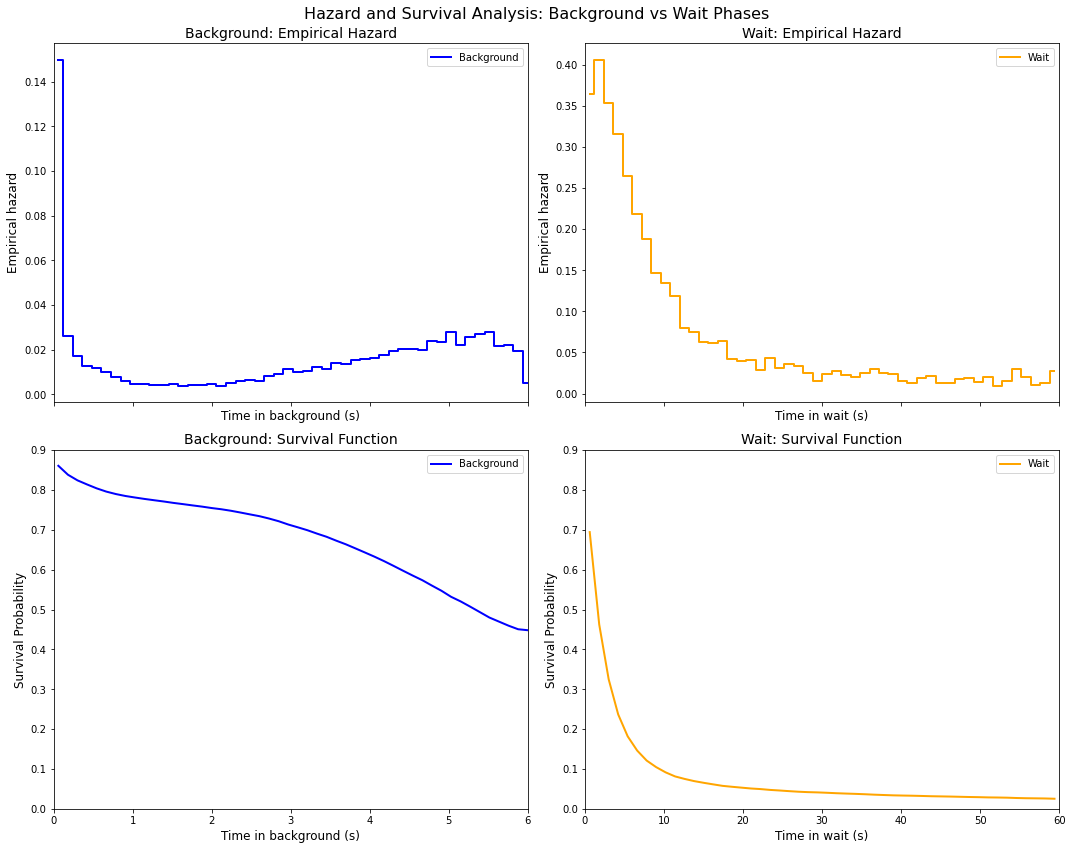

In [18]:
# Create 2x2 subplot layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), sharex='col')

# Background Hazard
ax1.step(cent_bg, haz_bg, where="mid", label="Background", linewidth=2, color='blue')
ax1.set_xlabel("Time in background (s)", fontsize=12)
ax1.set_ylabel("Empirical hazard", fontsize=12)
ax1.set_title("Background: Empirical Hazard", fontsize=14)
ax1.set_xlim(0, 6)
ax1.legend()

# Wait Hazard
ax2.step(cent_w, haz_w, where="mid", label="Wait", linewidth=2, color='orange')
ax2.set_xlabel("Time in wait (s)", fontsize=12)
ax2.set_ylabel("Empirical hazard", fontsize=12)
ax2.set_title("Wait: Empirical Hazard", fontsize=14)
ax2.set_xlim(0, 60)
ax2.legend()

# Background Survival
ax3.plot(cent_bg_surv, surv_bg, linewidth=2, color='blue', label='Background')
ax3.set_xlabel('Time in background (s)', fontsize=12)
ax3.set_ylabel('Survival Probability', fontsize=12)
ax3.set_title('Background: Survival Function', fontsize=14)
ax3.set_ylim(0, 0.9)
ax3.legend()

# Wait Survival
ax4.plot(cent_w_surv, surv_w, linewidth=2, color='orange', label='Wait')
ax4.set_xlabel('Time in wait (s)', fontsize=12)
ax4.set_ylabel('Survival Probability', fontsize=12)
ax4.set_title('Wait: Survival Function', fontsize=14)
ax4.set_ylim(0, 0.9)
ax4.legend()

plt.suptitle('Hazard and Survival Analysis: Background vs Wait Phases', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(f'{analysis_folder}/hazard_and_survival.png', dpi=300, bbox_inches='tight')

# Analysis for RZ062


In [19]:
# Filter sessions for RZ062
sessions_062 = sessions_training.loc[sessions_training['mouse'] == 'RZ062']


In [20]:
# Stitch events for RZ062
events_stitched_062 = stitch_all_events(data_folder, sessions_062)


In [21]:
# Filter licks for RZ062
licks_062 = events_stitched_062[(events_stitched_062['key'] == 'lick') & (events_stitched_062['value'] == 1) & (events_stitched_062['state'] != 'in_consumption')]


In [22]:
# Get directory list and filter trials for RZ062
dir_list_062 = events_stitched_062.dir.unique()
trials_062 = trials_training.loc[trials_training['dir'].isin(dir_list_062)]


RZ062 Lick Rate Analysis:
All trials - Peak time: 3.069 s
Good trials - Peak time: 3.169 s
Not good trials - Peak time: 3.069 s

bg_drawn mean: 1.000 s


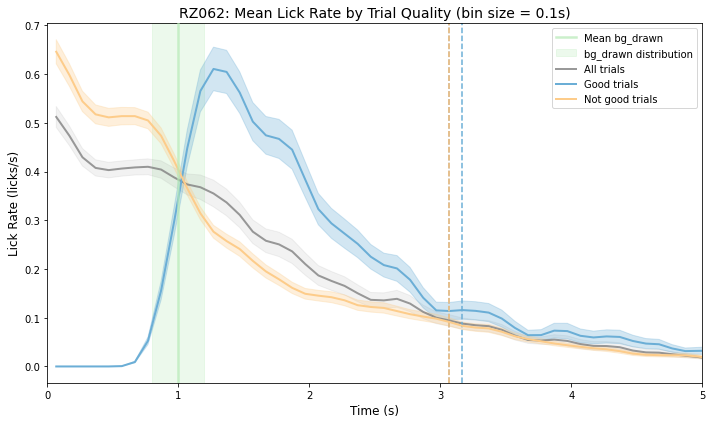

In [28]:
# Lick rate by trial quality for RZ062
bin_size = 0.1
bins = np.arange(licks_062['trial_time'].min(), licks_062['trial_time'].max() + bin_size, bin_size)
bin_centers = (bins[:-1] + bins[1:]) / 2

results_062 = {}
for label, mask, color in [
    ('All trials', slice(None), 'gray'),
    ('Good trials', licks_062['good_trial'] == True, lighter_blue),
    ('Not good trials', licks_062['good_trial'] == False, lighter_orange)
]:
    mean, sem = binned_rate_normalized(licks_062[mask], bins, bin_size, bin_centers)
    mean_smooth = gaussian_filter1d(mean, sigma=1)
    sem_smooth = gaussian_filter1d(sem, sigma=1)
    time_mask = (bin_centers >= 3) & (bin_centers <= 7)
    peak_idx = np.argmax(mean_smooth[time_mask])
    peak_time = bin_centers[time_mask][peak_idx]
    results_062[label] = dict(mean=mean_smooth, sem=sem_smooth, color=color, peak_time=peak_time)

print("RZ062 Lick Rate Analysis:")
for label, res in results_062.items():
    print(f"{label} - Peak time: {res['peak_time']:.3f} s")

# Calculate bg_drawn statistics for RZ062
bg_mean_062 = trials_062['bg_drawn'].mean()
bg_low_062 = trials_062['bg_drawn'].min()
bg_high_062 = trials_062['bg_drawn'].max()
print(f"\nbg_drawn mean: {bg_mean_062:.3f} s")

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bg_drawn shading first (so it's in the background)
ax.axvline(bg_mean_062, color='#b6eab6', linestyle='-', linewidth=2.5, label='Mean bg_drawn', zorder=10, alpha=0.7)
ax.axvspan(bg_low_062, bg_high_062, alpha=0.25, color='#b6eab6', label='bg_drawn distribution', zorder=1)

# Plot lick rates
for label, res in results_062.items():
    ax.plot(
        bin_centers, res['mean'], linewidth=2, color=res['color'], label=label,
        alpha=0.8 if label=='All trials' else 1
    )
    ax.fill_between(
        bin_centers, res['mean'] - res['sem'], res['mean'] + res['sem'],
        alpha=0.1 if label=='All trials' else 0.3, color=res['color']
    )
    ax.axvline(
        res['peak_time'], color=res['color'],
        linestyle='--',
        linewidth=1.5,
        alpha=1
    )

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Lick Rate (licks/s)', fontsize=12)
ax.set_title(f'RZ062: Mean Lick Rate by Trial Quality (bin size = {bin_size}s)', fontsize=14)
ax.set_xlim(0, 5)
ax.legend()
plt.tight_layout()
plt.savefig(f'{analysis_folder}/lick_rate_by_trial_quality_RZ062.png', dpi=300, bbox_inches='tight')


In [24]:
# Prepare per-trial times dataframe for RZ062
trials_sorted_062 = trials_062.sort_values(by=['dir', 'session_trial_num'])
trial_data_062 = trials_sorted_062.copy()

# Background phase: time to first lick or bg_length if no lick; event indicator
trial_data_062['t_bg'] = np.where(
    trial_data_062['first_lick'].notna() & (trial_data_062['first_lick'] < trial_data_062['bg_length']),
    trial_data_062['first_lick'],
    trial_data_062['bg_length']
)
trial_data_062['e_bg'] = ((trial_data_062['first_lick'].notna()) & (trial_data_062['first_lick'] < trial_data_062['bg_length'])).astype(int)

# Wait phase: time_waited and event indicator (not miss_trial)
trial_data_062['t_wait'] = trial_data_062['time_waited']
trial_data_062['e_wait'] = (~trial_data_062['miss_trial']).astype(int)

# Compute hazards for RZ062
cent_bg_062, haz_bg_062 = empirical_hazard(trial_data_062["t_bg"], trial_data_062["e_bg"], bins=50)
cent_w_062, haz_w_062 = empirical_hazard(trial_data_062["t_wait"], trial_data_062["e_wait"], bins=50)


In [25]:
# Convert hazards to survival functions for RZ062
cent_bg_surv_062, surv_bg_062 = hazard_to_survival(cent_bg_062, haz_bg_062)
cent_w_surv_062, surv_w_062 = hazard_to_survival(cent_w_062, haz_w_062)


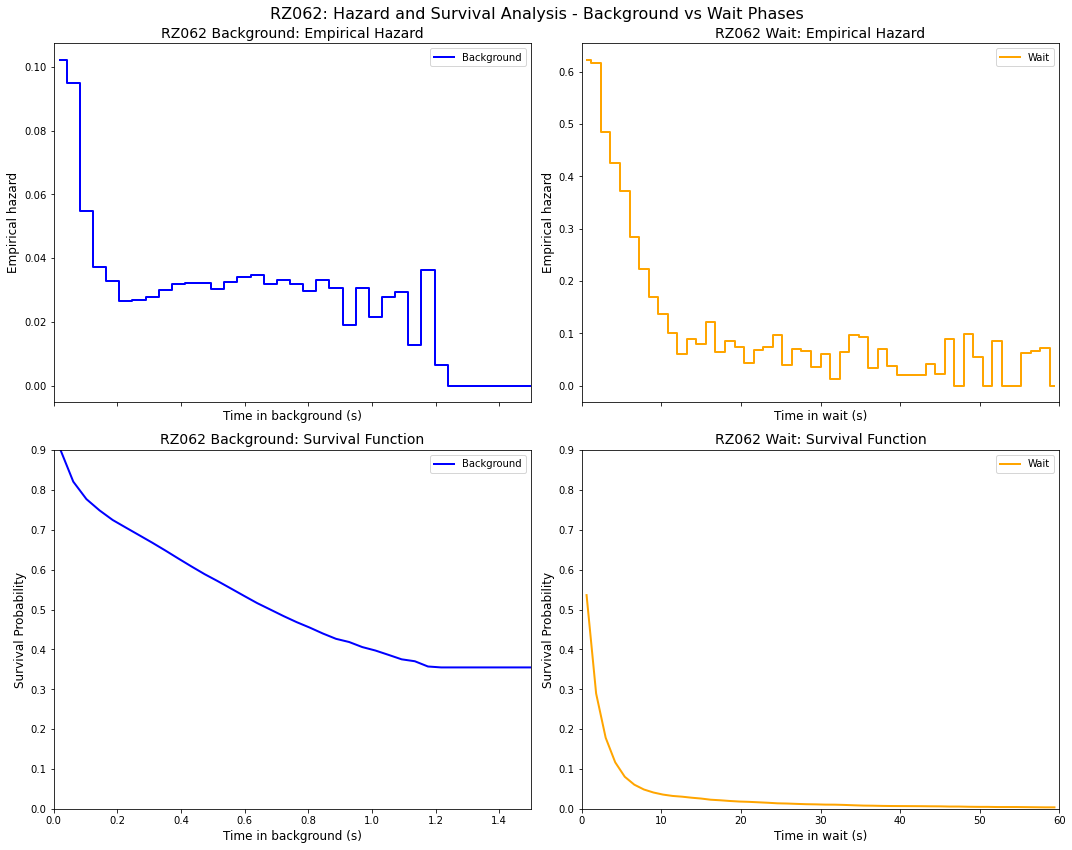

In [30]:
# Create 2x2 subplot layout for RZ062
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), sharex='col')

# Background Hazard
ax1.step(cent_bg_062, haz_bg_062, where="mid", label="Background", linewidth=2, color='blue')
ax1.set_xlabel("Time in background (s)", fontsize=12)
ax1.set_ylabel("Empirical hazard", fontsize=12)
ax1.set_title("RZ062 Background: Empirical Hazard", fontsize=14)
ax1.set_xlim(0, 1.5)
ax1.legend()

# Wait Hazard
ax2.step(cent_w_062, haz_w_062, where="mid", label="Wait", linewidth=2, color='orange')
ax2.set_xlabel("Time in wait (s)", fontsize=12)
ax2.set_ylabel("Empirical hazard", fontsize=12)
ax2.set_title("RZ062 Wait: Empirical Hazard", fontsize=14)
ax2.set_xlim(0, 60)
ax2.legend()

# Background Survival
ax3.plot(cent_bg_surv_062, surv_bg_062, linewidth=2, color='blue', label='Background')
ax3.set_xlabel('Time in background (s)', fontsize=12)
ax3.set_ylabel('Survival Probability', fontsize=12)
ax3.set_title('RZ062 Background: Survival Function', fontsize=14)
ax3.set_ylim(0, 0.9)
ax3.legend()

# Wait Survival
ax4.plot(cent_w_surv_062, surv_w_062, linewidth=2, color='orange', label='Wait')
ax4.set_xlabel('Time in wait (s)', fontsize=12)
ax4.set_ylabel('Survival Probability', fontsize=12)
ax4.set_title('RZ062 Wait: Survival Function', fontsize=14)
ax4.set_ylim(0, 0.9)
ax4.legend()

plt.suptitle('RZ062: Hazard and Survival Analysis - Background vs Wait Phases', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig(f'{analysis_folder}/hazard_and_survival_RZ062.png', dpi=300, bbox_inches='tight')
